In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

import scipy

In [2]:
import importlib  

module = importlib.import_module('0) APIs')
detect_and_refine_boundingBox = module.detect_and_refine_boundingBox

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

../images/C128_4.4LOW.BMP


Text(0.5, 1.0, 'Original image')

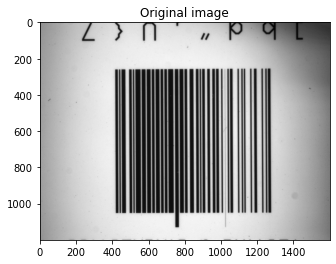

In [4]:
image_path = f'../images/{images_paths[0]}'
print(image_path)
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   

plt.figure()
plt.imshow(gray, 'gray')
plt.title('Original image')  

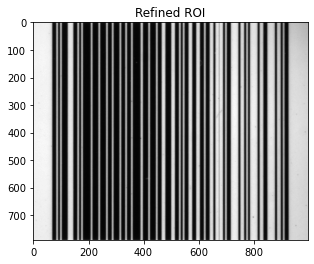

In [5]:
roi_image, bb_points_sorted_rot, bb_width, bb_height = detect_and_refine_boundingBox(image, 
                            use_same_threshold=False, compute_barcode_structure_algorithm=1, verbose_timing=False,
                            outlier_detection_level=0.02, visualization_dict={'visualize_refined_roi':True})

## COMPUTING THE SCAN LINES

In [6]:
bb_height

790

In [7]:
scanlines_indices = np.linspace(start=0, stop=bb_height, num=12, dtype=int)[1:-1]
scanlines_indices

array([ 71, 143, 215, 287, 359, 430, 502, 574, 646, 718])

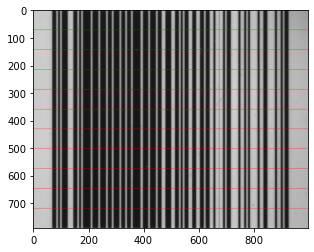

In [8]:
roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanlines_indices,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

## NORMALIZING THE IMAGE

In [10]:
roi_image_norm = 100*(roi_image/255)

In [10]:
roi_image_norm

array([[78, 77, 77, ..., 61, 60, 58],
       [76, 78, 78, ..., 60, 60, 59],
       [77, 78, 76, ..., 60, 59, 60],
       ...,
       [76, 76, 76, ..., 68, 69, 69],
       [76, 76, 76, ..., 69, 69, 69],
       [76, 77, 77, ..., 69, 69, 69]])

In [11]:
roi_image_norm

array([[78, 77, 77, ..., 61, 60, 58],
       [76, 78, 78, ..., 60, 60, 59],
       [77, 78, 76, ..., 60, 59, 60],
       ...,
       [76, 76, 76, ..., 68, 69, 69],
       [76, 76, 76, ..., 69, 69, 69],
       [76, 77, 77, ..., 69, 69, 69]])

In [12]:
roi_image_norm = np.rint(100*(roi_image/255))

In [13]:
roi_image_norm

array([[78., 78., 77., ..., 61., 60., 58.],
       [76., 78., 78., ..., 60., 60., 59.],
       [77., 79., 77., ..., 61., 60., 60.],
       ...,
       [76., 77., 76., ..., 68., 69., 69.],
       [76., 77., 77., ..., 69., 69., 69.],
       [77., 78., 78., ..., 69., 69., 69.]])

## COMPUTING THE PARAMETERS ON ONE SCANLINE
We focus on one scanline, and we compute the parameters.

<IPython.core.display.Javascript object>


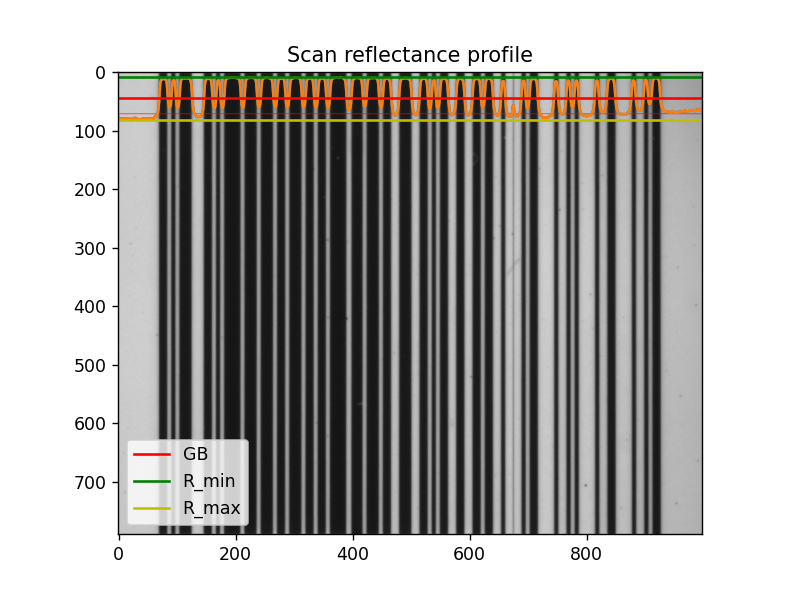

In [36]:
scanline_index = scanlines_indices[0]#math.ceil(bb_height/2)

roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanline_index,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

In [37]:
scanline = roi_image_norm[scanline_index, :]

In [38]:
plt.plot(scanline)
plt.title('Scan reflectance profile')

Text(0.5, 1.0, 'Scan reflectance profile')

### R_min, R_max, SC, GB

In [39]:
R_min = scanline.min()
R_max = scanline.max()

In [40]:
R_min, R_max

(8.235294117647058, 80.7843137254902)

In [41]:
SC = R_max - R_min
SC

72.54901960784314

In [42]:
GB = R_min + SC/2
GB

44.509803921568626

In [43]:
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.axhline(R_min, c='g', label='R_min')
plt.axhline(R_max, c='y', label='R_max')
plt.title('Scan reflectance profile')
plt.legend()

The wrong black line within a space can be noticed.

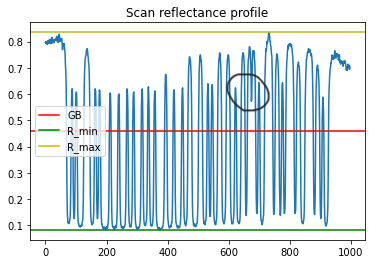

### Edges

In [44]:
mask = (scanline<GB).astype(int)
print(mask)
print()
mask_1 = np.append([0],mask[:-1])
print(mask_1) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [45]:
edges_mask = np.abs(mask - mask_1).astype(bool)
edges_mask

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,

In [46]:
np.indices((mask.shape[0],))

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [47]:
edges_indices = np.indices(mask.shape)[0][edges_mask]
edges_indices

array([ 70,  85,  90,  98, 104, 126, 146, 161, 167, 175, 181, 210, 215,
       237, 243, 265, 271, 286, 292, 314, 320, 335, 341, 356, 361, 390,
       398, 418, 424, 446, 452, 467, 480, 501, 515, 529, 535, 543, 549,
       564, 577, 592, 605, 620, 626, 641, 654, 662, 689, 697, 703, 717,
       745, 752, 765, 773, 779, 787, 814, 822, 835, 850, 877, 885, 897,
       906, 911, 927])

In [48]:
n_elements = len(edges_indices)+1

<IPython.core.display.Javascript object>


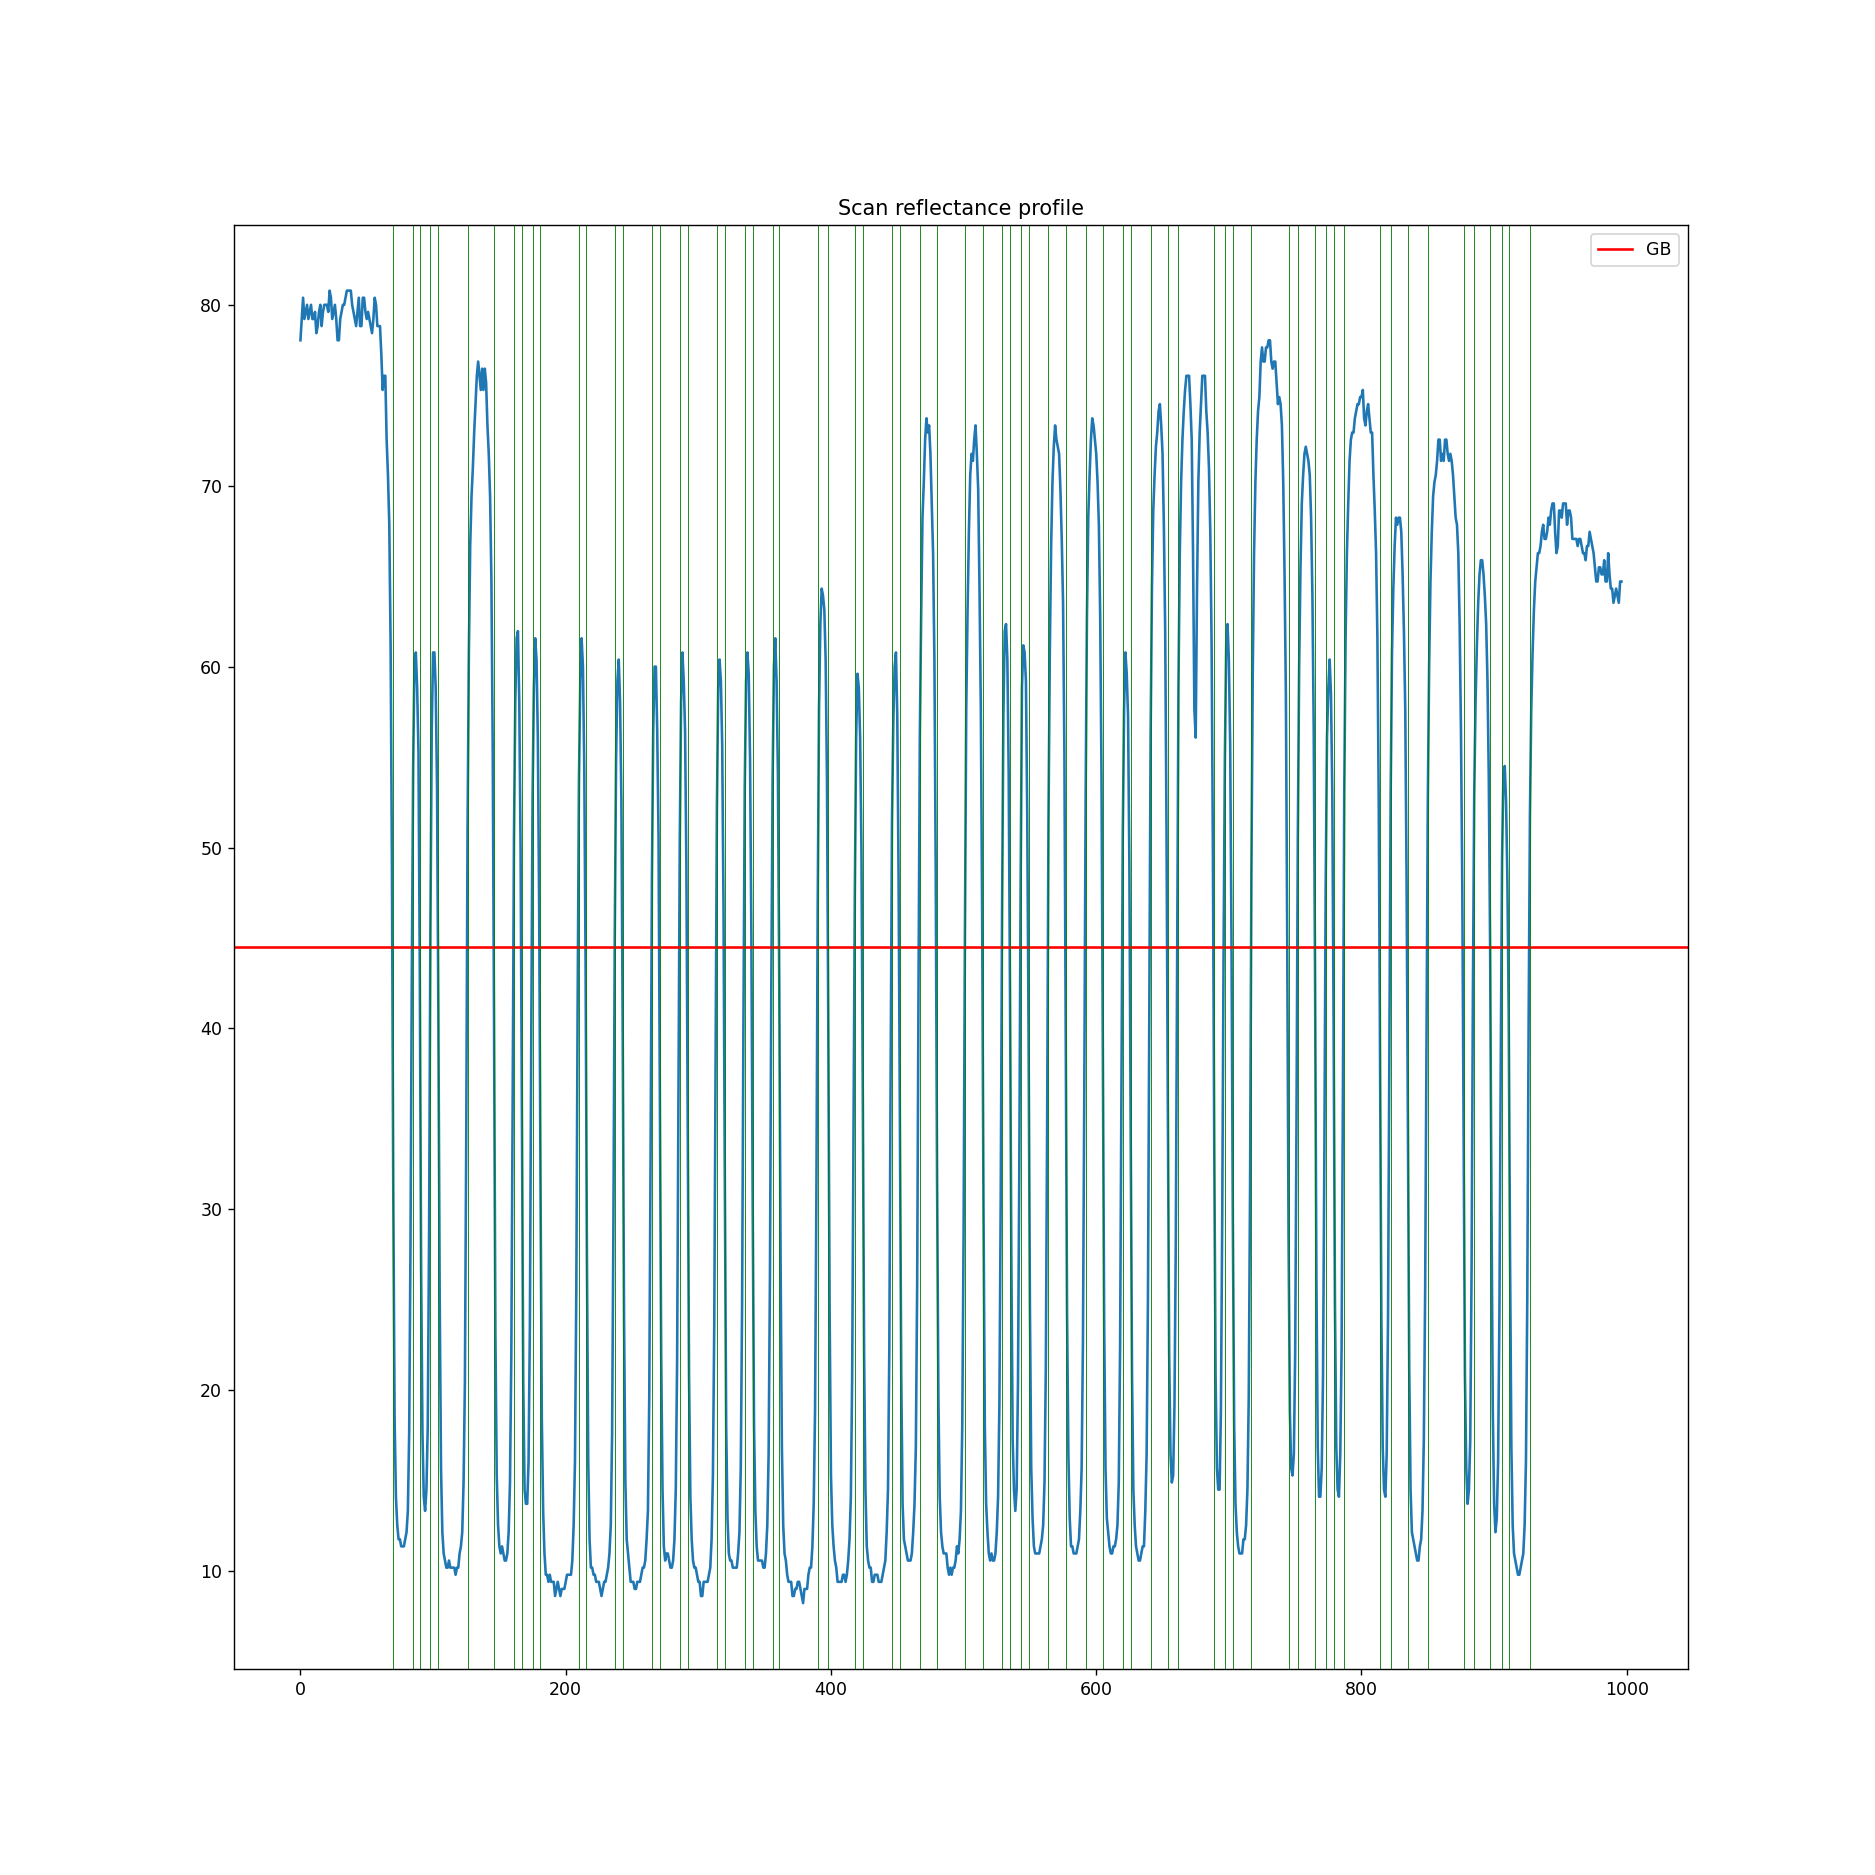

In [49]:
%matplotlib notebook
plt.figure(figsize=(15,15))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
for i in edges_indices:
    plt.axvline(i, c='g', lw=0.5)
plt.title('Scan reflectance profile')
plt.legend()

### Finding the peaks and the valleys

In [50]:
peaks_indices = scipy.signal.find_peaks(scanline)
peaks_indices = peaks_indices[0]
peaks_indices

array([  2,   5,   8,  11,  15,  19,  22,  26,  36,  44,  47,  51,  56,
        63,  87, 100, 112, 134, 137, 139, 152, 164, 177, 188, 194, 212,
       240, 267, 276, 288, 316, 337, 358, 375, 393, 409, 420, 434, 449,
       472, 474, 490, 495, 506, 509, 521, 532, 545, 569, 597, 622, 648,
       669, 681, 699, 725, 730, 734, 738, 758, 776, 801, 805, 826, 828,
       858, 861, 863, 867, 890, 908, 937, 941, 944, 949, 953, 956, 964,
       972, 979, 983, 986, 992], dtype=int64)

<IPython.core.display.Javascript object>


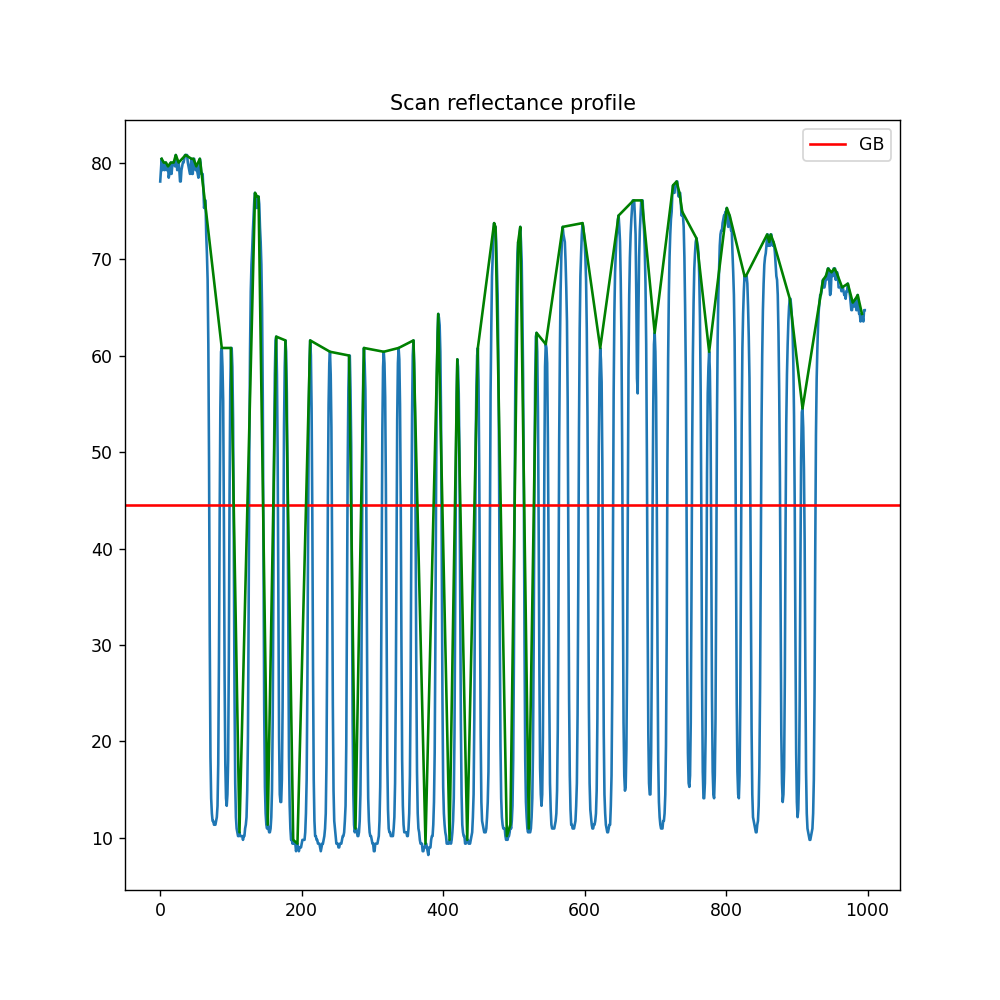

In [51]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot(peaks_indices, scanline[peaks_indices], c='g')
plt.title('Scan reflectance profile')
plt.legend()

In [52]:
valleys_indices = scipy.signal.find_peaks(100-scanline)
valleys_indices = valleys_indices[0]
valleys_indices

array([  3,   6,   9,  12,  16,  21,  24,  28,  42,  45,  50,  54,  62,
        77,  94, 110, 117, 136, 138, 151, 154, 170, 187, 192, 196, 227,
       252, 275, 279, 302, 327, 349, 371, 379, 406, 411, 431, 437, 459,
       473, 489, 491, 496, 507, 520, 522, 539, 555, 584, 611, 632, 657,
       675, 692, 709, 726, 733, 737, 748, 768, 783, 803, 818, 827, 842,
       860, 862, 866, 880, 901, 918, 938, 942, 947, 951, 955, 963, 969,
       977, 981, 984, 990, 994], dtype=int64)

<IPython.core.display.Javascript object>


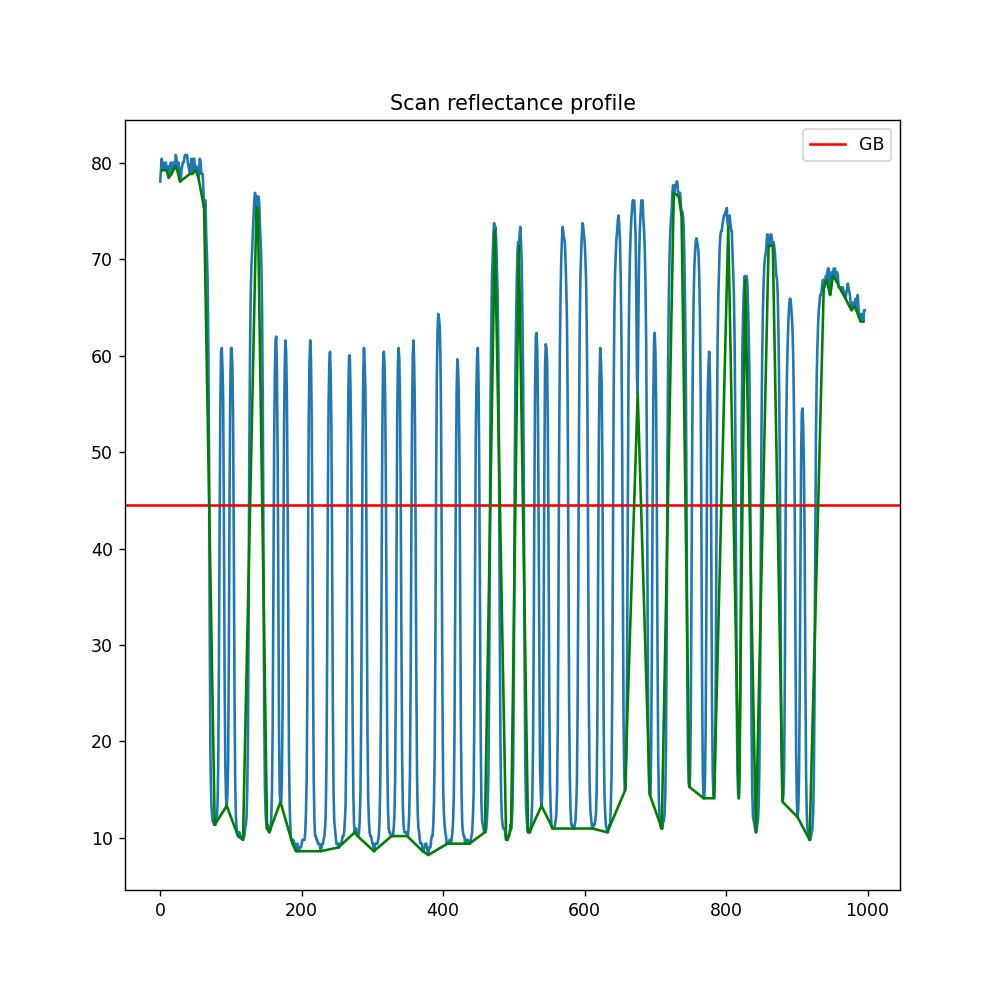

In [53]:
%matplotlib notebook
plt.figure(figsize=(8,8))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot(valleys_indices, scanline[valleys_indices], c='g')
plt.title('Scan reflectance profile')
plt.legend()

### EC_min

In [45]:
ERN_list = []
element = scanline[:edges_first_indices[0]]
ERN_list.append(element.max()-element.min())
for i, edge_first_index in enumerate(edges_first_indices): 
    if i>=len(edges_first_indices)-1:
        element = scanline[edge_first_index:]
    else:
        element = scanline[edge_first_index:edges_first_indices[i+1]]
    ERN_list.append(element.max()-element.min())
    
ERN_max = max(ERN_list)

DEFECTS = ERN_max / SC

DEFECTS

0.4868421052631579

### Defects

In [54]:
n_elements

69

In [55]:
scanline.shape

(997,)

In [62]:
ERN_list = []
peaks_valleys_elements_list = []

for i in range(n_elements):
    if i==0:
        element_first_index = 0
        element_last_index = edges_indices[0]
    elif i<n_elements-1:
        element_first_index = edges_indices[i-1]
        element_last_index = edges_indices[i]
    else:
        element_first_index = edges_indices[n_elements-2]
        element_last_index = scanline.shape[0]-1
    peaks_indices_within_element = peaks_indices[np.logical_and(peaks_indices>=element_first_index,peaks_indices<=element_last_index)]
    valleys_indices_within_element = valleys_indices[np.logical_and(valleys_indices>=element_first_index,valleys_indices<=element_last_index)]
    if peaks_indices_within_element.size==0 or valleys_indices_within_element.size==0:
        ERN_list.append(0)
        peaks_valleys_elements_list.append((None,None))
        continue
    peaks_within_element = scanline[peaks_indices_within_element]
    valleys_within_element = scanline[valleys_indices_within_element]
    ERN_list.append(peaks_within_element.max()-valleys_within_element.min())
    peaks_valleys_elements_list.append((peaks_indices_within_element[np.argmax(peaks_within_element)],valleys_indices_within_element[np.argmin(valleys_within_element)]))
    
ERN_max = max(ERN_list)

DEFECTS = ERN_max / SC

DEFECTS     

0.2756756756756757

<IPython.core.display.Javascript object>


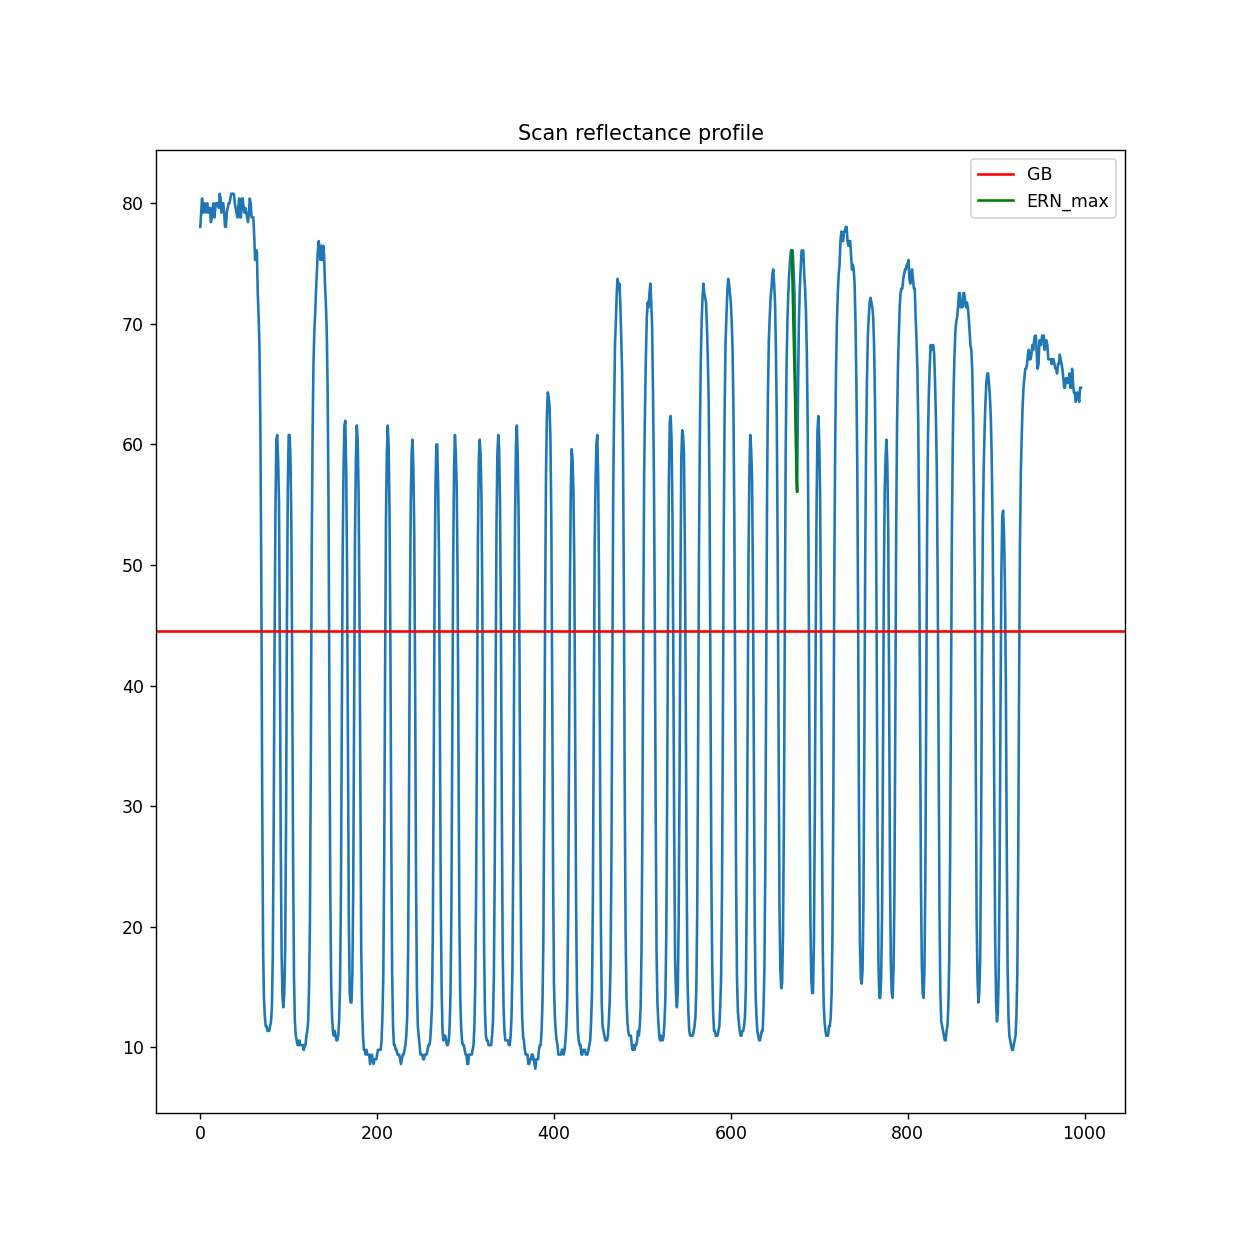

In [65]:
# Visualize ERN_max
peak_index, valley_index = peaks_valleys_elements_list[np.argmax(ERN_list)]
peak_value, valley_value = scanline[peak_index], scanline[valley_index]

%matplotlib notebook
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([peak_index, valley_index], [peak_value, valley_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

In [103]:
ERN_list = []
element = scanline[:edges_first_indices[0]]
ERN_list.append(element.max()-element.min())
for i, edge_first_index in enumerate(edges_first_indices): 
    if i>=len(edges_first_indices)-1:
        element = scanline[edge_first_index:]
    else:
        element = scanline[edge_first_index:edges_first_indices[i+1]]
    ERN_list.append(element.max()-element.min())
    
ERN_max = max(ERN_list)

DEFECTS = ERN_max / SC

DEFECTS

0.4868421052631579

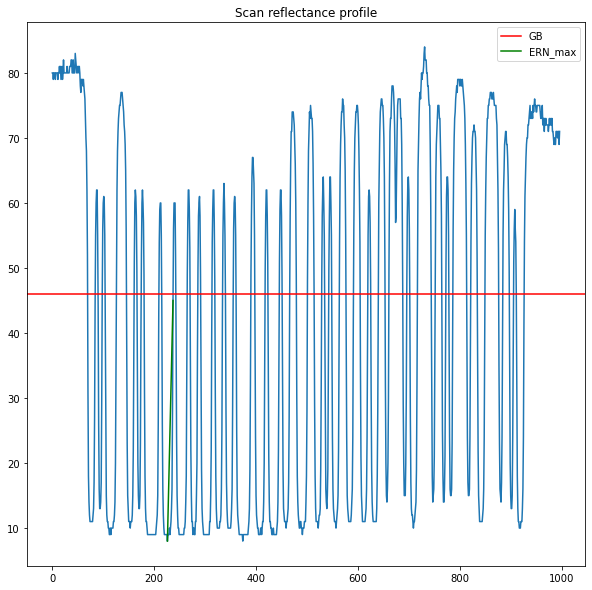

In [104]:
# Visualize ERN_max
ERN_max_edge_index = np.argmax(ERN_list)
if ERN_max_edge_index==0:
    element = scanline[:edges_first_indices[0]]
    element_first_index = 0
elif ERN_max_edge_index<len(ERN_list)-1:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:edges_first_indices[ERN_max_edge_index]]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
else:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
    
max_index = np.argmax(element) + element_first_index
max_value = np.max(element)
min_index = np.argmin(element) + element_first_index
min_value = np.min(element)

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([min_index, max_index], [min_value, max_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

In [105]:
scanline[max_index]

45.0

In [106]:
GB

46.0

In [108]:
roi_image[scanline_index, max_index]

116